In [1]:
# Install required packages if not installed
!pip install torch torchvision albumentations matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, clear_output

In [5]:
# Define Emotion Labels
EMOTIONS = ['angry', 'happy', 'neutral', 'sad']

# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = EMOTIONS
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.exists(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(cls_dir, img_name))
                        self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Data Augmentation
def load_data():
    print("Loading dataset...")

    train_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=40, translate=(0.25, 0.25), scale=(0.75, 1.25)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train_dataset = EmotionDataset(root_dir='fer2013/fer2013/train', transform=train_transform)
    test_dataset = EmotionDataset(root_dir='fer2013/fer2013/test', transform=val_transform)

    return train_dataset, test_dataset


In [7]:
# Define ResNet18 Model
class EmotionNetResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionNetResNet, self).__init__()

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Modify first layer for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Unfreeze last layers
        for param in self.resnet.layer3.parameters():
            param.requires_grad = True
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        # Replace final fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


In [18]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, patience=10):
    best_acc = 0.0
    train_losses, train_accuracies, val_accuracies = [], [], []

    early_stop_counter = 0  # Tracks epochs without improvement

    for epoch in range(num_epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, test_loader, device)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        scheduler.step(train_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best Model Saved (Accuracy: {best_acc:.2f}%)")
            early_stop_counter = 0  # Reset counter if validation improves
        else:
            early_stop_counter += 1  # Increase counter if no improvement

        # **Early stopping check**
        if early_stop_counter >= patience:
            print(f"Early Stopping triggered after {epoch+1} epochs! No improvement for {patience} consecutive epochs.")
            break  # Stop training

    # Plot final results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='red')
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training Progress")
    plt.savefig("training_progress.png")  # Save the plot
    plt.show()


In [19]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100 * correct / total

Loading dataset...
Epoch 1/100 | Train Loss: 1.4754 | Train Acc: 32.08% | Val Acc: 41.10%
Best Model Saved (Accuracy: 41.10%)
Epoch 2/100 | Train Loss: 1.3398 | Train Acc: 40.31% | Val Acc: 49.71%
Best Model Saved (Accuracy: 49.71%)
Epoch 3/100 | Train Loss: 1.2486 | Train Acc: 46.30% | Val Acc: 55.37%
Best Model Saved (Accuracy: 55.37%)
Epoch 4/100 | Train Loss: 1.1913 | Train Acc: 50.33% | Val Acc: 58.67%
Best Model Saved (Accuracy: 58.67%)
Epoch 5/100 | Train Loss: 1.1407 | Train Acc: 53.75% | Val Acc: 60.00%
Best Model Saved (Accuracy: 60.00%)
Epoch 6/100 | Train Loss: 1.1101 | Train Acc: 56.16% | Val Acc: 61.82%
Best Model Saved (Accuracy: 61.82%)
Epoch 7/100 | Train Loss: 1.0831 | Train Acc: 57.82% | Val Acc: 63.85%
Best Model Saved (Accuracy: 63.85%)
Epoch 8/100 | Train Loss: 1.0664 | Train Acc: 59.06% | Val Acc: 65.20%
Best Model Saved (Accuracy: 65.20%)
Epoch 9/100 | Train Loss: 1.0468 | Train Acc: 60.37% | Val Acc: 64.31%
Epoch 10/100 | Train Loss: 1.0319 | Train Acc: 61.56% 

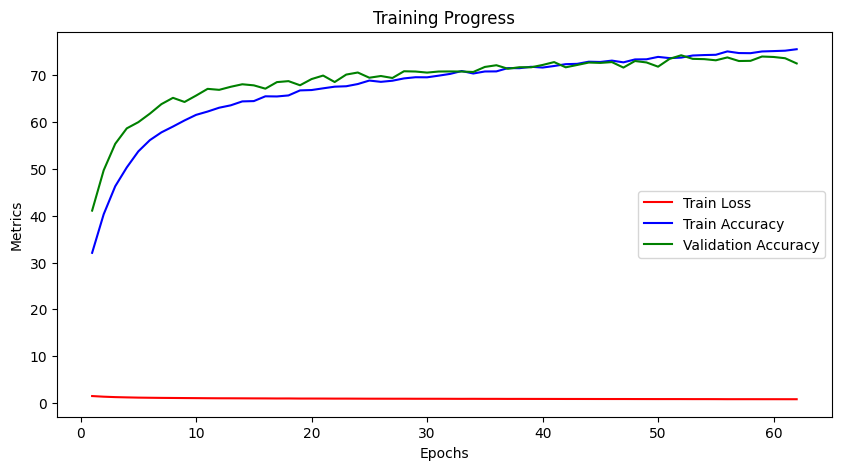

In [20]:
def main():
    torch.manual_seed(42)
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset, test_dataset = load_data()
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    model = EmotionNetResNet().to(DEVICE)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100, device=DEVICE)

if __name__ == "__main__":
    main()
